# Data cleaning

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import json
import os
import string
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

data_dir="./"
profiles_path = os.path.join(data_dir, 'linkedin.json')

In [2]:
# Read the data from the JSON file https://drive.google.com/open?id=1fXcY3pQc32sqdaOPft9EeKFMpqbYNTbN
# reading the first 1,000,000 profile
num_profiles_from_JSON = 1000000
profiles = []

for line in open(profiles_path):
    if len(profiles) < num_profiles_from_JSON:
        line = json.loads(line)
        profiles.append(line)
        
    else:
        break

print('Number of profiles loaded from JSON:', len(profiles))

Number of profiles loaded from JSON: 1000000


In [3]:
# Function that remove punctuation from strings
def remove_punctuation(s):
    translator = str.maketrans('', '', string.punctuation) 
    return s.translate(translator)

In [4]:
import nltk
from nltk.corpus import wordnet
import random
random.seed(2)

# Extract features from list of dictionaries and put into a dataframe
feature_extraction_list = ['skills','specilities','interests','experience','education','summary','honors','industry','group']
df = pd.DataFrame(columns=feature_extraction_list)
rows_list = []

# Parameters for checking English
number_of_word_to_test = 20 # Number of random words picked from 'experience' to check for English
non_eng_threshold = 0.25 # Percentage of non-english words allowed during checking before removing a profile

print('Checking language...')
num_profiles_with_features = 0
num_profiles_lang_not_en = 0
for i in profiles:
    #only select profiles with data for experience, education, and skills
    if ("experience" in i) and ("education" in i) and ("skills" in i):
        num_profiles_with_features = num_profiles_with_features + 1

        #check if 'industry' string is in English
        if 'industry' in i:
            industry_is_english = True
            word_list = remove_punctuation(str(i['industry'])).lower().split()
            for k in word_list:
                if not wordnet.synsets(k):
                    industry_is_english = False
        else:
            industry_is_english = True

        #check if there are enough words in 'experience' that are in English
        if industry_is_english == True:
            word_list = remove_punctuation(str(i['experience'])).lower().split()
            word_list_rand = []
            for k in range(number_of_word_to_test):
                word_list_rand.append(word_list[random.randrange(1, len(word_list))])
            eng_count = 0
            for k in word_list_rand:
                if wordnet.synsets(k):
                    eng_count = eng_count + 1           
            if eng_count/len(word_list_rand) >= (1 - non_eng_threshold):
                is_english = True
            else:
                is_english = False
        else: 
            is_english = False

        #if the profile is qualified to be in English, extract the features to put in a dataframe    
        if is_english == True:            
            dict1 = {}
            for j in feature_extraction_list:
                if j in i:
                    dict1[j] = i[j]
                else:
                    if j in ['specilities','interests','summary','industry']:
                        dict1[j] = ''
                    elif j in ['skills','honors','group']:
                        dict1[j] = []
                    else:
                        dict1[j] = float('nan')            
            rows_list.append(dict1)
        else:
            num_profiles_lang_not_en = num_profiles_lang_not_en + 1

df = pd.DataFrame(rows_list)
print('Number of profiles with experience, education, and skills:', num_profiles_with_features)
print('Number of profiles removed because it is not in english:', num_profiles_lang_not_en)
print('Percentage of profiles removed because it is not in english: ', round(num_profiles_lang_not_en/num_profiles_with_features*100, 2),'%', sep='')
print('Number of profiles loaded into the dataFrame:', len(rows_list))

Checking language...
Number of profiles with experience, education, and skills: 455792
Number of profiles removed because it is not in english: 348160
Percentage of profiles removed because it is not in english: 76.39%
Number of profiles loaded into the dataFrame: 107632


In [5]:
#split data from education and experience into the following columns
df['occupation'] = ''
df['company'] = ''
df['major'] = ''
df['institution'] = ''
df['degree'] = ''

for index, row in df.iterrows():
    if type(row["experience"]) == list:
        temp_occupation = []
        temp_company = []
        for i in row['experience']:
            if 'title' in i:
                temp_occupation.append(i['title'])
            else:
                temp_occupation.append('')
            if 'org' in i:
                temp_company.append(i['org'])
            else:
                temp_company.append('')        
        if len(temp_occupation) == 0:
            row['occupation'] = []
        else:
            row['occupation'] = temp_occupation
        if len(temp_company) == 0:
            row['company'] = []
        else:
            row['company'] = temp_company
    
    if type(row["education"]) == list:
        temp_institution = []
        temp_major = []
        temp_degree = []
        for i in row['education']:
            if 'name' in i:
                temp_institution.append(i['name'])
            else:
                temp_institution.append('')
            if 'major' in i:
                temp_major.append(i['major'])
            else:
                temp_major.append('')              
            if 'degree' in i:
                temp_degree.append(i['degree'])
            else:
                temp_degree.append('') 
                
        if len(temp_institution) == 0:
            row['institution'] = []
        else:
            row['institution'] = temp_institution
        if len(temp_major) == 0:
            row['major'] = []
        else:
            row['major'] = temp_major
        if len(temp_degree) == 0:
            row['degree'] = []
        else:
            row['degree'] = temp_degree            
                
    if (type(row['group']) == dict and 'affiliation' in row['group']):
        row['group'] = row['group']['affiliation']
    else:
        row['group'] = []
        
    if row['occupation'] == '':
        row['occupation'] = []
    if row['company'] == '':
        row['company'] = []
    if row['major'] == '':
        row['major'] = []
    if row['institution'] == '':
        row['institution'] = []

In [6]:
# Manually standardize degrees
for index, row in df.iterrows():
    if type(row['degree']) == list:
        temp_degree = []
        for degree in row['degree']:
            degree = remove_punctuation(degree.upper())

            if 'PHD' in degree:
                degree = 'PHD'
            if "POST GRADUATE" in degree:
                degree = "POST GRADUATE"
            if "MASTER OF SCIENCE" in degree or 'MSC' in degree or 'MS' in degree:
                degree = 'MS'
            if "MASTERS" in degree or "MASTER" in degree:
                degree = 'MASTER'
            if 'MBA' in degree:
                degree = 'MBA'
            if "BACHELOR OF SCIENCE" in degree or "BSC" in degree or "BS" in degree:
                degree = 'BS'
            if "BACHELOR OF ARTS" in degree or "BA" in degree:
                degree = 'BA'
            if "BACHELORS" in degree or "BACHELOR" in degree:
                degree = 'BACHELOR'
            if 'ASSOCIATE' in degree:
                degree = 'ASSOCIATE'
            if 'SCIENCE' in degree:
                degree = 'SCIENCE'
            if 'ENGINEERING' in degree or 'ENGINEER' in degree:
                degree = 'ENGINEERING'
            if 'BUSINESS' in degree:
                degree = 'BUSINESS'
            if "MANAGEMENT" in degree:
                degree = "MANAGEMENT"
            if 'RESEARCH' in degree:
                degree = 'RESEARCH'
            if 'HIGH' in degree or 'SECONDARY' in degree:
                degree = 'HIGH'
            useless_list = ['CERTIFICATE', 'CERTIFICATION', 'CERTIFIED', 'COURSE', 'DE', 'DEGREE', 'DIPLOMA', 'LEVELS', 'LICENCE', 'PROGRAM', 'SCHOOL']
            for i in useless_list:
                if i in degree:
                    degree = ""
            
            temp_degree.append(degree)
        if len(temp_degree) == 0:
            row['degree'] = []
        else:
            row['degree'] = temp_degree

In [7]:
# Calculating year of work experience based on the year of data collection and the year of graduation for bachelor degree
# Year of entering the workforce is assumed to be the year of graduating with a Bachelor degree or the year of earliest work experience, which one is earlier.
year_of_data_collection = 2019

df['year_of_work_experience'] = ''
for index, row in df.iterrows():
    year_min = year_of_data_collection
    if type(row['degree']) == list:
        for i in range(0,len(row['degree'])):
            if row['degree'][i] == 'HIGH':
                break
            if 'end' in row['education'][i]:
                try:
                    year_temp = parser.parse(row['education'][i]['end']).year
                except:
                    pass
                    
                if year_temp < year_min:
                    year_min = year_temp
                
    if type(row['experience']) == list:
        for i in range(0,len(row['experience'])):
            if 'start' in row['experience'][i]:
                try:
                    year_temp = parser.parse(row['experience'][i]['start']).year
                except:
                    pass
                
                if year_temp < year_min:
                    year_min = year_temp                
        
    row['year_of_work_experience'] = year_of_data_collection - year_min       

    if row['year_of_work_experience'] == '':
        row['year_of_work_experience'] = float('nan')
        
print('Percentage of profiles with value for work years:', 
      df['year_of_work_experience'].count()/df.shape[0]*100,
      '%')

Percentage of profiles with value for work years: 100.0 %


In [8]:
#clean up the dataframe
df = df[['skills','specilities','interests',
               'institution','degree','major',
               'summary','honors','industry',
               'occupation','company',
               'year_of_work_experience','group']].copy()

df.head()

,skills,specilities,interests,institution,degree,major,summary,honors,industry,occupation,company,year_of_work_experience,group
0,"[DNA, Nanotechnology, Molecular Biology, Softw...",,"personal genomics, nanotechnology","[Harvard University, Yale University]","[PHD, BS]","[Biophysics, Computer Science]",I am interested in inventing new methods to co...,[],Research,"[Assistant Professor, Technology Development F...","[UCSF, Wyss Institute for Biologically Inspire...",16,[]
1,"[Interactive Marketing, Content Strategy, Affi...","Internet Marketing, Interactive Marketing, Dig...","Digital Photography, Tennis, Internet Marketin...",[University of Virginia],[BA],[History],"Love to work on deadline & data-driven, dynami...",[],Internet,"[Social Media Marketing Manager, Board of Dire...","[Coca-Cola, Atlanta Interactive Marketing Asso...",21,[]
2,"[Primavera, Revit MEP, AutoCAD, Engineering, H...",,"Project Management, Innovative Designs, New Te...","[University of Petroleum & Energy Studies, IIT...","[, , , , ]","[, , , , ]",More than 08 yrs of experience with hands on e...,[# Selected in ARMY through SSB (Technical Gra...,Oil & Energy,[Manager (International Business Development &...,"[VOITH Hydro Pvt Ltd., VOITH Hydro Pvt. Ltd., ...",22,[]
3,"[Talent Acquisition, Recruiting, Talent Manage...",,"Organizational development, personal developme...","[Universitatea „Transilvania” din Brașov, Univ...","[BA, ]","[Psychology & Science of Education, ]",RecruitmentInternal communicationTrainingNew h...,[],Human Resources,"[Recruitment consultant, Scientific Staffing C...","[CGI, Kelly Services, Carmeuse, Education Inst...",18,[]
4,"[Brand Management, Integrated Marketing, Telev...",,"Broadcast Design, Television, Creativity, Music.",[Instituto de Diseño de Caracas],[],[],Accomplished Chief Creative Officer with 15+ y...,"[Promax and BDA World Gold Awards, New York Fe...",Broadcast Media,"[Creative Services, Vice President, Creative S...","[Discovery Communications, Warner Channel, War...",28,[]


# Word2Vec

In [9]:
# Import Word2Vec and nltk libraries
import re
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.models.phrases import Phraser, Phrases
import unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer

In [10]:
# Function that removes English stopwords
def remove_stopwords(words):
    stopword_list = stopwords.words('english')
    for word in words:
        if word in stopword_list:
            words.remove(word)
    return words

In [11]:
# Clean, lemmatize and tokenize the "skills" column for all profiles
lemmatizer = WordNetLemmatizer()

skills = list()
for index,row in df.iterrows():
    r = list()
    for i in row['skills']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    skills.append(r)

In [12]:
# Use bigram to create Word2Vec model for "skills"
all_sentences2 = []
for text in skills:
    all_sentences2 += text
    
phrases = Phrases(all_sentences2, min_count=1, threshold=1)
bigram=Phraser(phrases)
all_sentences2 = list(bigram[all_sentences2])

model2 = Word2Vec(all_sentences2, 
                 min_count=100,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [13]:
# Clean, lemmatize and tokenize the "major" column for all profiles
major = list()
for index,row in df.iterrows():
    r = list()
    for i in row['major']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    major.append(r)

In [14]:
# Use bigram to create Word2Vec model for "major"
all_sentences3 = []
for text in major:
    all_sentences3 += text
    
phrases = Phrases(all_sentences3, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences3 = list(bigram[all_sentences3])

model3 = Word2Vec(all_sentences3, 
                 min_count=200,   # Ignore words that appear less than this
                 size=100,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [15]:
# Clean and tokenize the "degree" column for all profiles
degree = list()
for index,row in df.iterrows():
    r = list()
    for i in row['degree']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=nltk.word_tokenize(i)
        i=remove_stopwords(i)
        r.append(i)
    degree.append(r)

In [16]:
# Use bigram to create Word2Vec model for "degree"
all_sentences4 = []
for text in degree:
    all_sentences4 += text
    
phrases = Phrases(all_sentences4, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences4 = list(bigram[all_sentences4])

model4 = Word2Vec(all_sentences4, 
                 min_count=200,   # Ignore words that appear less than this
                 size=50,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [17]:
# Clean and lemmatize the "institution" column for all profiles
institution = list()
for index,row in df.iterrows():
    r = list()
    for i in row['institution']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        r.append(i)
    institution.append(r)

In [18]:
# Use bigram to create Word2Vec model for "institution"
all_sentences5 = []
for text in institution:
    all_sentences5.append(list(text))
    
phrases = Phrases(all_sentences5, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences5 = list(bigram[all_sentences5])

model5 = Word2Vec(all_sentences5, 
                 min_count=20,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [19]:
# Clean, lemmatize and tokenize the "industry" column for all profiles
industry = list()
for i in df['industry']:
    r = list()
    if type(i) == float:
        i = ""
    i=i.translate(str.maketrans('', '', string.punctuation))
    i=i.lower()
    i=lemmatizer.lemmatize(i,pos='n')
    i=nltk.word_tokenize(i)
    i=remove_stopwords(i)
    r.append(i)
    industry.append(r)

In [20]:
# Use bigram to create Word2Vec model for "industry"
all_sentences6 = []
for text in industry:
    all_sentences6 += text
    
phrases = Phrases(all_sentences6, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences6 = list(bigram[all_sentences6])

model6 = Word2Vec(all_sentences6, 
                 min_count=50,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [21]:
# Clean and lemmatize the "company" column for all profiles
company = list()
for index,row in df.iterrows():
    r = list()
    for i in row['company']:
        i=i.translate(str.maketrans('', '', string.punctuation))
        i=i.lower()
        i=lemmatizer.lemmatize(i,pos='n')
        r.append(i)
    company.append(r)

In [22]:
# Use bigram to create Word2Vec model for "company"
all_sentences7 = []
for text in company:
    all_sentences7.append(list(text))
    
phrases = Phrases(all_sentences7, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentences7 = list(bigram[all_sentences7])

model7 = Word2Vec(all_sentences7, 
                 min_count=20,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [23]:
print(len(model2.wv.vocab)) # skill
print(len(model3.wv.vocab)) # major
print(len(model4.wv.vocab)) # degree
print(len(model5.wv.vocab)) # institution
print(len(model6.wv.vocab)) # industry
print(len(model7.wv.vocab)) # company

1949
152
38
1456
146
1354


# Hierarchical clustering

In [24]:
# Number of clusters (tunable)
n_cluster_2 = 50
n_cluster_3 = 20
n_cluster_5 = 50
n_cluster_6 = 10
n_cluster_7 = 50
n_cluster_label = 50

In [25]:
from sklearn.cluster import AgglomerativeClustering

# Print "skills" clusters
n_clusters = n_cluster_2
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model2vec_list = list()
for i in list(model2.wv.vocab.keys()):
    model2vec_list.append(model2[i])
model2vec_cluster = list(cluster.fit_predict(model2vec_list))

model2vec = dict()
for i in range(len(model2.wv.vocab.keys())):
    model2vec[list(model2.wv.vocab.keys())[i]] = model2vec_cluster[i]
print('\n')
model2_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model2vec.items() if v == i])
    model2_cluster_list.append([k for k,v in model2vec.items() if v == i])
    print('\n')



['mobile', 'network', 'architecture', 'object_oriented', 'web', 'data', 'database', 'user_interface', 'security', 'user_experience', 'web_application', 'solution', 'hardware']


['content', 'sales', 'brand', 'product', 'key_account', 'account', 'community', 'workforce', 'campaign', 'customer', 'field', 'channel', 'client', 'human_capital', 'category', 'materials', 'sponsorship']


['healthcare_information', 'home', 'writing', 'trading', 'industry', 'food', 'policy', 'trade', 'consumer', 'research', 'science', 'products', 'high']


['nanotechnology', 'molecular_biology', 'interactive_marketing', 'web_analytics', 'power_plants', 'epc', 'project_execution', 'revit', 'power_generation', 'primavera_p6', 'creative_direction', 'cs', 'joomla', 'drupal', 'magento', 'sdlc', 'benefits_administration', 'hr_policies', 'onboarding', 'performance_appraisal', 'fmla', 'succession_planning', 'employee_engagement', 'organizational_development', 'recruitmentretention', 'competitive_analysis', 'blackberr

In [26]:
# Print "major" clusters
n_clusters = n_cluster_3
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model3vec_list = list()
for i in list(model3.wv.vocab.keys()):
    model3vec_list.append(model3[i])
model3vec_cluster = list(cluster.fit_predict(model3vec_list))

model3vec = dict()
for i in range(len(model3.wv.vocab.keys())):
    model3vec[list(model3.wv.vocab.keys())[i]] = model3vec_cluster[i]
print('\n')
model3_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model3vec.items() if v == i])
    model3_cluster_list.append([k for k,v in model3vec.items() if v == i])
    print('\n')



['history', 'english', 'general_studies', 'art', 'biology', 'literature', 'philosophy', 'german', 'spanish', 'english_literature', 'french', 'music', 'liberal_arts', 'geography', 'english_language']


['public_relations', 'communication', 'communications', 'arts', 'journalism', 'advertising']


['computer_science', 'science', 'applied_mathematics', 'sciences', 'computing', 'informatics']


['electronic_engineering', 'systems', 'electronics_communication', 'computer', 'information', 'engineering', 'electrical_engineering', 'technology', 'telecommunication', 'software_engineering', 'telecommunications', 'electronics', 'electrical', 'software']


['education', 'public_administration', 'development', 'administration', 'criminal_justice', 'social_work', 'relations', 'health', 'policy', 'nursing']


['medicine', 'geology', 'chemistry', 'applied', 'biochemistry', 'environmental', 'microbiology']


['marketing', 'management', 'strategy', 'finance', 'strategic_management', 'mba', 'information

In [27]:
# Print "institution" clusters
n_clusters = n_cluster_5
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model5vec_list = list()
for i in list(model5.wv.vocab.keys()):
    model5vec_list.append(model5[i])
model5vec_cluster = list(cluster.fit_predict(model5vec_list))

model5vec = dict()
for i in range(len(model5.wv.vocab.keys())):
    model5vec[list(model5.wv.vocab.keys())[i]] = model5vec_cluster[i]
print('\n')
model5_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model5vec.items() if v == i])
    model5_cluster_list.append([k for k,v in model5vec.items() if v == i])
    print('\n')



['delhi university', 'university of madras', 'symbiosis institute of management studies', 'kendriya vidyalaya', 'indian institute of management bangalore', 'university of pune', 'indian institute of management calcutta', 'indira gandhi national open university', 'indian institute of management ahmedabad']


['university of nottingham', 'university of exeter', 'liverpool john moores university', 'university of newcastleupontyne', 'university of warwick  warwick business school', 'cardiff university  prifysgol caerdydd', 'university of leicester', 'the university of manchester', 'the manchester metropolitan university', 'the university of reading', 'loughborough university', 'university of southampton', 'aston university', 'the university of birmingham', 'university of liverpool', 'university of the west of england', 'chartered institute of marketing', 'the open university_the open university']


['king saud university', 'american university of beirut', 'universiteit gent', 'imperial c

In [28]:
# Print "industry" clusters
n_clusters = n_cluster_6
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model6vec_list = list()
for i in list(model6.wv.vocab.keys()):
    model6vec_list.append(model6[i])
model6vec_cluster = list(cluster.fit_predict(model6vec_list))

model6vec = dict()
for i in range(len(model6.wv.vocab.keys())):
    model6vec[list(model6.wv.vocab.keys())[i]] = model6vec_cluster[i]
print('\n')
model6_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model6vec.items() if v == i])
    model6_cluster_list.append([k for k,v in model6vec.items() if v == i])
    print('\n')



['research', 'oil', 'energy', 'human', 'resources', 'broadcast', 'media', 'food', 'beverages', 'design', 'computer', 'online', 'banking', 'services', 'management', 'financial', 'goods', 'real', 'estate', 'medical', 'devices', 'building', 'materials', 'mining', 'metals', 'higher', 'law', 'practice', 'production', 'market', 'information', 'electronics', 'graphic', 'executive', 'office', 'apparel', 'fashion', 'leisure', 'travel', 'tourism', 'defense', 'space', 'public', 'policy', 'government', 'administration', 'aviation', 'aerospace', 'events', 'relations', 'architecture', 'planning', 'legal', 'environmental', 'safety', 'enforcement', 'facilities', 'political', 'civic_social', 'commercial', 'financiers', 'individual_family', 'glass_ceramics', 'concrete', 'paper_forest', 'products']


['venture', 'equity', 'markets']


['mechanical', 'industrial', 'engineering', 'automation', 'civil']


['capital', 'private']


['professional', 'training', 'coaching']


['internet', 'pharmaceutical', 'r

In [29]:
# Print "company" clusters
n_clusters = n_cluster_7
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

model7vec_list = list()
for i in list(model7.wv.vocab.keys()):
    model7vec_list.append(model7[i])
model7vec_cluster = list(cluster.fit_predict(model7vec_list))

model7vec = dict()
for i in range(len(model7.wv.vocab.keys())):
    model7vec[list(model7.wv.vocab.keys())[i]] = model7vec_cluster[i]
print('\n')
model7_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in model7vec.items() if v == i])
    model7_cluster_list.append([k for k,v in model7vec.items() if v == i])
    print('\n')



['best buy', 'target', 'target_target', 'best buy_best buy', 'jcpenney_jcpenney', 'jcpenney']


['nike_nike', 'dell', 'hewlettpackard', 'nike', 'dell_dell', 'hewlettpackard_hewlettpackard', 'eastman kodak', 'eastman kodak_eastman kodak']


['ernst  young_ernst  young', 'ernst  young', 'kpmg', 'barclays bank_barclays bank', 'pwc', 'lloyds tsb', 'axa', 'royal bank of scotland', 'pwc_pwc', 'macquarie bank', 'barclays bank', 'lloyds banking group_lloyds banking group', 'kpmg_kpmg', 'westpac', 'royal bank of scotland_royal bank of scotland', 'commonwealth bank of australia', 'suncorp', 'amp', 'lloyds banking group', 'nationwide building society', 'commonwealth bank of australia_commonwealth bank of australia']


['microsoft_microsoft', 'microsoft corporation', 'microsoft', 'yahoo', 'carnegie mellon university', 'linkedin_linkedin', 'yahoo_yahoo', 'linkedin', 'amazoncom', 'ebay', 'microsoft corporation_microsoft corporation', 'amazoncom_amazoncom', 'ebay_ebay']


['wells fargo home mortgag

# Putting feature clusters into dummy variables in numpy array

In [30]:
# Skills
for i in range(len(model2_cluster_list)):
    model2_cluster_list[i] = set(model2_cluster_list[i])

# Major
for i in range(len(model3_cluster_list)):
    model3_cluster_list[i] = set(model3_cluster_list[i])

# Degree into the same format
model4_cluster_list = list()
for i in range(len(model4.wv.vocab.keys())):
    model4_cluster_list.append(list(model4.wv.vocab.keys())[i])
print('List of degree types:\n', model4_cluster_list)

# Institution
for i in range(len(model5_cluster_list)):
    model5_cluster_list[i] = set(model5_cluster_list[i])
    
# Industry
for i in range(len(model6_cluster_list)):
    model6_cluster_list[i] = set(model6_cluster_list[i])
    
# Company
for i in range(len(model7_cluster_list)):
    model7_cluster_list[i] = set(model7_cluster_list[i])

List of degree types:
 ['phd', 'bs', 'ba', 'master', 'ms', 'hnd', 'business', 'md', 'management', 'high', 'associate', 'aa', 'btech', 'ab', 'na', 'jd', 'bcom', 'aas', 'beng', 'post_graduate', 'hsc', 'b_sc', 'bcomm', 'bfa', 'engineering', 'ssc', 'meng', 'science', 'pgdm', 'hons', 'b_tech', 'llb', '21', 'llm', 'juris_doctor', 'level', 'b', 'graduate']


In [31]:
# Work out the dimension of the numpy array and create it
array_rows = len(degree)
len_2 = len(model2_cluster_list) # skill (50)
len_3 = len(model3_cluster_list) # major (20)
len_4 = len(model4_cluster_list) # degree (no clustering: 38)
len_5 = len(model5_cluster_list) # institution (50)
len_6 = len(model6_cluster_list) # industry (10)
len_7 = len(model7_cluster_list) # company (50)

feature_columns = (len_2 + len_3 + len_4 + len_5 + len_6 + len_7 + 1)
feature_array = np.zeros((array_rows, feature_columns))
print('Feature array dimensions: ', feature_array.shape)

Feature array dimensions:  (107632, 219)


In [32]:
print('Number of rows and columns for each array:')

# Skills
print('skills:', len(skills), ', ', len_2)
for person in range(len(skills)):
    for item in skills[person]:
        for word in item:
            for cluster in range(len_2):
                if word in model2_cluster_list[cluster]:
                    feature_array[person, (cluster)] += 1

# Major
print('major:', len(major), ', ', len_3)
for person in range(len(major)):
    for item in major[person]:
        for word in item:
            for cluster in range(len_3):
                if word in model3_cluster_list[cluster]:
                    feature_array[person, (len_2 + cluster)] += 1
                    
# Degree
print('degree:', len(degree), ', ', len_4)
for person in range(len(degree)):
    for item in degree[person]:
        for word in item:
            for cluster in range(len_4):
                if word == model4_cluster_list[cluster]:
                    feature_array[person, (len_2 + len_3 + cluster)] += 1
                    
# Institution
print('institution:', len(institution), ', ', len_5)
for person in range(len(institution)):
    for item in institution[person]:
        for word in item:
            for cluster in range(len_5):
                if word in model5_cluster_list[cluster]:
                    feature_array[person, (len_2 + len_3 + len_4 + cluster)] += 1
                    
# Industry
print('industry:', len(industry), ', ', len_6)
for person in range(len(industry)):
    for item in industry[person]:
        for word in item:
            for cluster in range(len_6):
                if word in model6_cluster_list[cluster]:
                    feature_array[person, (len_2 + len_3 + len_4 + len_5 + cluster)] += 1

# Company
print('company:', len(company), ', ', len_7)
for person in range(len(company)):
    for item in company[person]:
        for word in item:
            for cluster in range(len_7):
                if word in model7_cluster_list[cluster]:
                    feature_array[person, (len_2 + len_3 + len_4 + len_5 + len_6 + cluster)] += 1
                    
# Years of work experiences
year_of_work = df['year_of_work_experience']
print('year_of_work_experience:', len(year_of_work), ', ', 1)
for person in range(len(year_of_work)):
    feature_array[person, (len_2 + len_3 + len_4 + len_5 + len_6 + len_7)] = year_of_work[person]
print('\n')
print('Sample feature row for one profile:\n', feature_array[:1])
print('\n')
print('Feature array dimensions: ', feature_array.shape)
print('\n')
print('Feature array sum: ', np.sum(feature_array))

Number of rows and columns for each array:
skills: 107632 ,  50
major: 107632 ,  20
degree: 107632 ,  38
institution: 107632 ,  50
industry: 107632 ,  10
company: 107632 ,  50
year_of_work_experience: 107632 ,  1


Sample feature row for one profile:
 [[ 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0

# Labeling

In [33]:
# Create a label column in the dataframe called "latest occupation"
df['latest occupation'] = ''
for index, row in df.iterrows():
    row['latest occupation'] = row['occupation'][0]
df.head()

,skills,specilities,interests,institution,degree,major,summary,honors,industry,occupation,company,year_of_work_experience,group,latest occupation
0,"[DNA, Nanotechnology, Molecular Biology, Softw...",,"personal genomics, nanotechnology","[Harvard University, Yale University]","[PHD, BS]","[Biophysics, Computer Science]",I am interested in inventing new methods to co...,[],Research,"[Assistant Professor, Technology Development F...","[UCSF, Wyss Institute for Biologically Inspire...",16,[],Assistant Professor
1,"[Interactive Marketing, Content Strategy, Affi...","Internet Marketing, Interactive Marketing, Dig...","Digital Photography, Tennis, Internet Marketin...",[University of Virginia],[BA],[History],"Love to work on deadline & data-driven, dynami...",[],Internet,"[Social Media Marketing Manager, Board of Dire...","[Coca-Cola, Atlanta Interactive Marketing Asso...",21,[],Social Media Marketing Manager
2,"[Primavera, Revit MEP, AutoCAD, Engineering, H...",,"Project Management, Innovative Designs, New Te...","[University of Petroleum & Energy Studies, IIT...","[, , , , ]","[, , , , ]",More than 08 yrs of experience with hands on e...,[# Selected in ARMY through SSB (Technical Gra...,Oil & Energy,[Manager (International Business Development &...,"[VOITH Hydro Pvt Ltd., VOITH Hydro Pvt. Ltd., ...",22,[],Manager (International Business Development & ...
3,"[Talent Acquisition, Recruiting, Talent Manage...",,"Organizational development, personal developme...","[Universitatea „Transilvania” din Brașov, Univ...","[BA, ]","[Psychology & Science of Education, ]",RecruitmentInternal communicationTrainingNew h...,[],Human Resources,"[Recruitment consultant, Scientific Staffing C...","[CGI, Kelly Services, Carmeuse, Education Inst...",18,[],Recruitment consultant
4,"[Brand Management, Integrated Marketing, Telev...",,"Broadcast Design, Television, Creativity, Music.",[Instituto de Diseño de Caracas],[],[],Accomplished Chief Creative Officer with 15+ y...,"[Promax and BDA World Gold Awards, New York Fe...",Broadcast Media,"[Creative Services, Vice President, Creative S...","[Discovery Communications, Warner Channel, War...",28,[],Creative Services


In [34]:
# Assign a unique multiclass label to each person's latest occupation (0-49)
latest_occupation = list()
for i in df['latest occupation']:
    r = list()
    i=i.translate(str.maketrans('', '', string.punctuation))
    i=i.replace(" ", "")
    i=i.lower()
    r.append(i)
    latest_occupation.append(r)

all_sentencesY = []
for text in latest_occupation:
    all_sentencesY.append(list(text))
    
phrases = Phrases(all_sentencesY, min_count=1,threshold=1)
bigram=Phraser(phrases)
all_sentencesY = list(bigram[all_sentencesY])

min_count = 5
modelY = Word2Vec(all_sentencesY, 
                 min_count=min_count,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

In [35]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

n_clusters = n_cluster_label
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward') 

modelYvec_list = list()
for i in list(modelY.wv.vocab.keys()):
    modelYvec_list.append(modelY[i])
modelYvec_cluster = list(cluster.fit_predict(modelYvec_list))

modelYvec = dict()
for i in range(len(modelY.wv.vocab.keys())):
    modelYvec[list(modelY.wv.vocab.keys())[i]] = modelYvec_cluster[i]

print('\n')
modelY_cluster_list = list()
for i in range(0,n_clusters):
    print([k for k,v in modelYvec.items() if v == i])
    modelY_cluster_list.append([k for k,v in modelYvec.items() if v == i])
    print('\n')



['frontofficemanager', 'director', 'senioroperationsmanager', 'assistantvicepresident', 'researchfellow', 'digitalmarketingmanager', 'creativedirector', 'projectarchitect', 'freelanceconsultant', 'quantitativeanalyst', 'directorofsales', 'technicalsalesmanager', 'principalassociate', 'assistantpropertymanager', 'seniortaxassociate', 'pastpresident', 'softwareengineerii', 'technicalarchitect', 'directorofengineering', 'vpofengineering', 'onlinemarketingmanager', 'contributingwriter', 'seniorandroiddeveloper', 'geologist', 'traineesolicitor', 'srhrmanager', 'graphicartist', 'workexperience', 'stylist', 'divisionmanager', 'modulelead', 'graduateresearchassistant', 'pricinganalyst', 'accountrepresentative', 'rdmanager', 'seniorhradvisor', 'territoryaccountmanager', 'humancapitalconsultant', 'headofdevelopment', 'customermarketingmanager', 'seniortaxmanager', 'financialaccountant', 'chiefgeologist', 'compensationmanager', 'creative', 'associatesoftwareengineer', 'strategymanager', 'acoust

In [36]:
modelY_cluster_list = list()
for i in range(len(modelY.wv.vocab.keys())):
    modelY_cluster_list.append(list(modelY.wv.vocab.keys())[i])
print('Number of distinct keys:', len(modelY_cluster_list))

# Check the number of latest occupations with no fewer than min_count = 5 occurrences
y_in_list = 0
for i in df['latest occupation']:
    i=i.translate(str.maketrans('', '', string.punctuation))
    i=i.replace(" ", "")
    i=i.lower()
    if i in modelY_cluster_list:
        y_in_list += 1
print('Number of profiles with no fewer than ', min_count, ' (latest occupation) occurrences:', y_in_list)
print('Percentage of profiles with no fewer than ', min_count, ' (latest occupation) occurrences:', y_in_list/len(rows_list))

Number of distinct keys: 1814
Number of profiles with no fewer than  5  (latest occupation) occurrences: 45340
Percentage of profiles with no fewer than  5  (latest occupation) occurrences: 0.421250185818344


In [37]:
# Build another model with min_count = 1
modelY2 = Word2Vec(all_sentencesY, 
                 min_count=1,   # Ignore words that appear less than this
                 size=200,      # Dimensionality of word embeddings
                 workers=16,     # Number of processors (parallelisation)
                 window=5,      # Context window for words during training
                 iter=30)       # Number of epochs training over corpus

y_class_array = np.zeros((len(df), 1))
y_class_array -= 1
print('Label array dimensions: ', y_class_array.shape)
modelY2_key_list = list(modelY2.wv.vocab.keys())

Label array dimensions:  (107632, 1)


In [38]:
# Fill the array
# Assign multiclass labels (0 - 49)
random.seed(2)
df_occup = pd.DataFrame(data = df['latest occupation'])
df_occup.columns = [''] * len(df_occup.columns)
for index,row in df_occup.iterrows():
    person=pd.Series.to_string(row)
    person=person.translate(str.maketrans('', '', string.punctuation))
    person=person.replace(" ", "")
    person=person.lower()
    if person in modelY_cluster_list:
        i = modelY_cluster_list.index(person)
        y_class_array[index] = modelYvec_cluster[i]
    else:
        for j in range(10):
            try:
                person_similar = modelY2.most_similar(person)[j][0]
            except KeyError:
                person_similar = ''
            if person_similar in modelY_cluster_list:
                i = modelY_cluster_list.index(person_similar)
                y_class_array[index] = modelYvec_cluster[i]
                break

In [39]:
n_neg1 = list(y_class_array).count([-1.])
print('Percentage of latest occupations with labels: ',1 - n_neg1/len(df))
print('\n')
print('Label array: ', y_class_array)

Percentage of latest occupations with labels:  0.5614315445220752


Label array:  [[14.]
 [39.]
 [-1.]
 ...
 [14.]
 [-1.]
 [-1.]]


In [40]:
# Convert int labels to str
y_class_array_str = []
for i in range(len(y_class_array)):
    y_class_array_str.append(str(int(list(y_class_array[i])[0])))

# Remove profiles with label = '-1' (Caution)
df_noneg1 = pd.DataFrame(feature_array)
df_noneg1['Latest Occupation'] = y_class_array_str
df_noneg = df_noneg1[df_noneg1['Latest Occupation'] != '-1']
feature_array_noneg = np.array(df_noneg.iloc[:,:len(feature_array[0,:])])
y_class_array_noneg = np.array(df_noneg.iloc[:,len(feature_array[0,:])])
print('Cleaned feature array: ', feature_array_noneg)
print('\n')
print('Cleaned label array: ', y_class_array_noneg)
print('\n')
print('Number of rows in feature array: ', len(feature_array_noneg))
print('\n')
print('Number of rows in label array: ', len(y_class_array_noneg))

Cleaned feature array:  [[ 0.  0.  0. ...  0.  0. 16.]
 [ 2.  3.  0. ...  0.  0. 21.]
 [ 0.  0.  0. ...  0.  0. 18.]
 ...
 [ 0.  1.  0. ...  0.  0. 13.]
 [ 0.  1.  0. ...  0.  0. 32.]
 [ 1.  2.  0. ...  0.  0. 27.]]


Cleaned label array:  ['14' '39' '19' ... '11' '12' '14']


Number of rows in feature array:  60428


Number of rows in label array:  60428


# Model buildup

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

random.seed(2)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(feature_array_noneg, y_class_array_noneg, random_state = 1, test_size = 0.2)

In [42]:
# Baseline model (always predict the label with the most training set occurrences)
import statistics 
from statistics import mode
base_pred = mode(y_train)
print('Baseline prediction for all the test set: ', base_pred)

s = 0
for i in range(len(y_test)):
    if int(y_test[i]) == int(base_pred):
        s += 1
print('Baseline test accuracy: ', s/len(y_test))

Baseline prediction for all the test set:  35
Baseline test accuracy:  0.043024987588945886


Text(0.5, 0, 'max_depth')

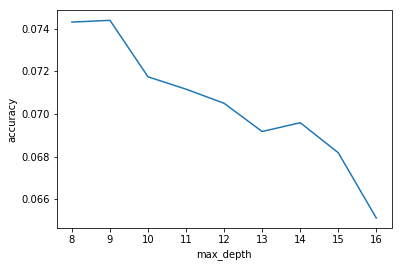

In [43]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Decision tree classification (tune max_depth)
max_depth_list = [8,9,10,11,12,13,14,15,16]
dtree_accuracy_temp = []
for max_depth in max_depth_list:
    dtree_model_temp = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)
    dtree_accuracy_temp.append(dtree_model_temp.score(X_test, y_test))
    
plt.plot(max_depth_list, dtree_accuracy_temp)
plt.ylabel('accuracy')
plt.xlabel('max_depth')

In [44]:
max_depth = max_depth_list[dtree_accuracy_temp.index(max(dtree_accuracy_temp))]
dtree_model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)
dtree_accuracy = dtree_model.score(X_test, y_test)
dtree_cm = confusion_matrix(y_test, dtree_predictions)
print('Decision tree test accuracy: ', dtree_accuracy)
print('\n')
print('Decision tree confusion matrix:\n', dtree_cm)
print('\n')
print('Decision tree important features:\n', dtree_model.feature_importances_)

Decision tree test accuracy:  0.0743835843124276


Decision tree confusion matrix:
 [[ 88   6   0 ...   0   0  31]
 [ 44  26   0 ...   0   0  14]
 [ 46   3   1 ...   0   0  16]
 ...
 [ 42   6   0 ...   0   0  19]
 [ 30   0   0 ...   0   0  23]
 [ 54  12   1 ...   1   0 194]]


Decision tree important features:
 [0.01126547 0.02582838 0.01274641 0.02242486 0.00592193 0.00405665
 0.00149857 0.00781198 0.00667867 0.00920499 0.00170634 0.04123056
 0.00836832 0.0090266  0.00308791 0.01071082 0.01251243 0.01261853
 0.00551443 0.00625933 0.00735597 0.00723774 0.01040075 0.00380157
 0.00140557 0.02803408 0.02085403 0.00342179 0.0062054  0.00939933
 0.01185397 0.01569893 0.00339991 0.00692885 0.02819092 0.01092565
 0.02177231 0.00188643 0.02343218 0.00145241 0.00961941 0.12254964
 0.00727419 0.02618854 0.00407124 0.0089324  0.00328133 0.
 0.00227413 0.01807377 0.0047292  0.00407449 0.01398334 0.02234091
 0.00282666 0.0014714  0.00374193 0.00291596 0.00185487 0.00391905
 0.00140274 0.0016694  0.

Text(0.5, 0, 'log_alpha')

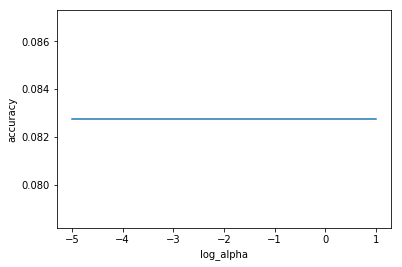

In [45]:
from sklearn.linear_model import RidgeClassifier

# Ridge Classifier (tune alpha)
log_alpha_list = [-5,-4,-3,-2,-1,0,1]
ridge_accuracy_temp = []
for log_alpha in log_alpha_list:
    ridge_model_temp = RidgeClassifier(alpha=np.exp(log_alpha), fit_intercept=True).fit(X_train, y_train)
    ridge_accuracy_temp.append(ridge_model_temp.score(X_test, y_test))
    
plt.plot(log_alpha_list, ridge_accuracy_temp)
plt.ylabel('accuracy')
plt.xlabel('log_alpha')

In [46]:
log_alpha = log_alpha_list[ridge_accuracy_temp.index(max(ridge_accuracy_temp))]
ridge_model = RidgeClassifier(alpha=np.exp(log_alpha), fit_intercept=True).fit(X_train, y_train)
ridge_predictions = ridge_model.predict(X_test)
ridge_accuracy = ridge_model.score(X_test, y_test)
ridge_cm = confusion_matrix(y_test, ridge_predictions)
print('Ridge test accuracy:\n', ridge_accuracy)
print('\n')
print('Ridge confusion matrix:\n', ridge_cm)

Ridge test accuracy:
 0.08274036074797286


Ridge confusion matrix:
 [[ 50  16   3 ...   3   0  61]
 [ 22  14   2 ...   1   0  47]
 [ 23   8   3 ...   6   0  28]
 ...
 [ 15   5   3 ...   8   0  35]
 [  9   3   0 ...   4   0  48]
 [ 15   8   2 ...   2   0 245]]


In [47]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier (tune n_estimators)
# Can only handle small n_estimators, or the memory will exceed.

rf_model = RandomForestClassifier(n_estimators = 40, n_jobs = -1).fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = rf_model.score(X_test, y_test)
rf_cm = confusion_matrix(y_test, rf_predictions)
print('RF test accuracy: ', rf_accuracy)
print('\n')
print('RF confusion matrix:\n', rf_cm)
print('\n')
print('RF important features:\n', rf_model.feature_importances_)

RF test accuracy:  0.07496276683766341


RF confusion matrix:
 [[ 65  22   6 ...   4   7  32]
 [ 37  30   5 ...   2   1  18]
 [ 17  19  13 ...   3   2  12]
 ...
 [ 34  12  11 ...  18   1  13]
 [ 17  14   6 ...   3   2  20]
 [ 22  18   7 ...   3   2 193]]


RF important features:
 [0.0150277  0.01738822 0.01792349 0.02604569 0.01787894 0.01507862
 0.01075832 0.01012372 0.01313021 0.01977903 0.00700512 0.01290174
 0.01140333 0.01259201 0.01857053 0.01248465 0.01103925 0.00806744
 0.00475292 0.01373874 0.00475452 0.01219254 0.01762476 0.01366448
 0.00977383 0.00949344 0.02064301 0.00831872 0.0144555  0.008513
 0.00547744 0.01162499 0.01250208 0.01431245 0.01696738 0.01721237
 0.00602541 0.01298023 0.01491649 0.00741958 0.01089488 0.01194042
 0.01492996 0.0241604  0.00597269 0.01561731 0.00833931 0.00791486
 0.00227837 0.02615444 0.01061154 0.00714194 0.01003941 0.01565031
 0.00949518 0.00598444 0.01763665 0.00378179 0.01277911 0.00654371
 0.00568192 0.00529629 0.00525011 0.0045723  0.    

Text(0.5, 0, 'n_neighbors')

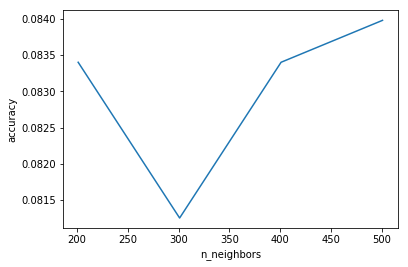

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# KNN classification (tune k)
n_neighbors_list = [201,301,401,501]
knn_accuracy_temp = []
for n_neighbors in n_neighbors_list:
    knn_model_temp = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X_train, y_train)
    knn_accuracy_temp.append(knn_model_temp.score(X_test, y_test))
    
plt.plot(n_neighbors_list, knn_accuracy_temp)
plt.ylabel('accuracy')
plt.xlabel('n_neighbors')

In [49]:
n_neighbors = n_neighbors_list[knn_accuracy_temp.index(max(knn_accuracy_temp))]
knn_model = KNeighborsClassifier(n_neighbors = n_neighbors, n_jobs = -1).fit(X_train, y_train) # Using all processors
knn_predictions = knn_model.predict(X_test)
knn_accuracy = knn_model.score(X_test, y_test)
knn_cm = confusion_matrix(y_test, knn_predictions)
print('KNN test accuracy: ', knn_accuracy)
print('\n')
print('KNN confusion matrix:\n', knn_cm)

KNN test accuracy:  0.08398146615919246


KNN confusion matrix:
 [[ 41   4  16 ...   1   0  52]
 [ 10  28   5 ...   0   0  30]
 [ 22   6  14 ...   1   0  26]
 ...
 [  9   8   8 ...   5   0  27]
 [ 11   2   3 ...   2   0  35]
 [ 22   6   4 ...   2   0 231]]


# Important features for individual occupation clusters

In [51]:
# Cluster 20. Typical words: 'founderceo', 'founderandceo', 'cofoundercto'.
# Cluster 21. Typical words: 'businessanalyst', 'financemanager', 'businessdevelopmentexecutive'.
# Cluster 22. Typical words: 'seniordeveloper', 'softwarearchitect', 'frontenddeveloper'.
# Assign binary label columns

y_train_19 = [0] * len(y_train)
y_train_20 = [0] * len(y_train)
y_train_21 = [0] * len(y_train)
y_test_19 = [0] * len(y_test)
y_test_20 = [0] * len(y_test)
y_test_21 = [0] * len(y_test)

for i in range(len(y_train)):
    if y_train[i] == '19':
        y_train_19[i] = 1
print(np.sum(y_train_19))

for i in range(len(y_train)):
    if y_train[i] == '20':
        y_train_20[i] = 1
print(np.sum(y_train_20))

for i in range(len(y_train)):
    if y_train[i] == '21':
        y_train_21[i] = 1
print(np.sum(y_train_21))

for i in range(len(y_test)):
    if y_test[i] == '19':
        y_test_19[i] = 1
print(np.sum(y_test_19))

for i in range(len(y_test)):
    if y_test[i] == '20':
        y_test_20[i] = 1
print(np.sum(y_test_20))

for i in range(len(y_test)):
    if y_test[i] == '21':
        y_test_21[i] = 1
print(np.sum(y_test_21))

929
1171
746
245
237
195


In [53]:
# Now try cluster 21
# Baseline
base_pred = mode(y_train_20)
print('Baseline prediction for all the test set: ', base_pred)

s = 0
for i in range(len(y_test_20)):
    if int(y_test_20[i]) == int(base_pred):
        s += 1
print('Baseline test accuracy: ', s/len(y_test_20))

Baseline prediction for all the test set:  0
Baseline test accuracy:  0.9803905345027304


Text(0.5, 0, 'max_depth')

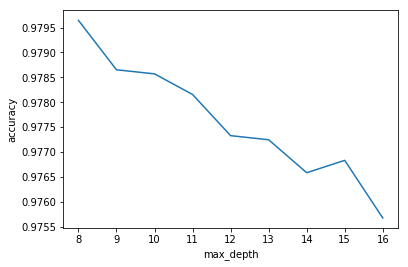

In [54]:
# Decision tree classification (tune max_depth)
max_depth_list = [8,9,10,11,12,13,14,15,16]
dtree_accuracy_temp = []
for max_depth in max_depth_list:
    dtree_model_temp = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train_20)
    dtree_accuracy_temp.append(dtree_model_temp.score(X_test, y_test_20))
    
plt.plot(max_depth_list, dtree_accuracy_temp)
plt.ylabel('accuracy')
plt.xlabel('max_depth')

In [55]:
max_depth = max_depth_list[dtree_accuracy_temp.index(max(dtree_accuracy_temp))]
dtree_model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train_20)
dtree_predictions = dtree_model.predict(X_test)
dtree_accuracy = dtree_model.score(X_test, y_test_20)
dtree_cm = confusion_matrix(y_test_20, dtree_predictions)
print('Decision tree test accuracy: ', dtree_accuracy)
print('\n')
print('Decision tree confusion matrix:\n', dtree_cm)
print('\n')
print('Decision tree important features:\n', dtree_model.feature_importances_)

Decision tree test accuracy:  0.9793149098130068


Decision tree confusion matrix:
 [[11836    13]
 [  237     0]]


Decision tree important features:
 [0.03347879 0.05665834 0.00451102 0.00412099 0.02031457 0.00698005
 0.         0.         0.         0.         0.         0.02138396
 0.02073293 0.03147236 0.         0.         0.         0.
 0.         0.00680844 0.         0.         0.01973589 0.
 0.04200646 0.         0.04023234 0.         0.01117199 0.
 0.         0.0185176  0.02148626 0.         0.01067708 0.03430846
 0.0925409  0.00232632 0.00847507 0.01184008 0.         0.01498308
 0.02681279 0.02111463 0.         0.01594381 0.         0.
 0.01104029 0.01191679 0.         0.00653038 0.00778725 0.01914318
 0.01490076 0.         0.02123785 0.         0.0048515  0.
 0.         0.         0.02520201 0.         0.         0.02154599
 0.010742   0.01117199 0.         0.         0.         0.
 0.03644198 0.         0.01594021 0.         0.00347664 0.
 0.         0.01489599 0.00467966

In [58]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier (tune n_estimators)
# Can only handle small n_estimators, or the memory will exceed.

rf_model = RandomForestClassifier(n_estimators = 40, n_jobs = -1).fit(X_train, y_train_20)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = rf_model.score(X_test, y_test_20)
rf_cm = confusion_matrix(y_test_20, rf_predictions)
print('RF test accuracy: ', rf_accuracy)
print('\n')
print('RF confusion matrix:\n', rf_cm)
print('\n')
print('RF important features:\n', rf_model.feature_importances_)

RF test accuracy:  0.9803077941419824


RF confusion matrix:
 [[11848     1]
 [  237     0]]


RF important features:
 [0.01476372 0.01730409 0.01228524 0.02262188 0.0155764  0.01434223
 0.00852005 0.01164569 0.01253041 0.01988306 0.00619136 0.01217992
 0.01011856 0.01294712 0.02002974 0.01107686 0.00991385 0.00708399
 0.00451068 0.01332685 0.00481612 0.01012377 0.01590135 0.0136299
 0.00828704 0.01031262 0.02057122 0.00751954 0.01332083 0.01028505
 0.00725769 0.0139904  0.01195051 0.01296028 0.01916044 0.01601004
 0.00925624 0.01173724 0.01437907 0.0089828  0.01042648 0.01309711
 0.01487259 0.02799399 0.00514555 0.00971687 0.00836871 0.00791131
 0.0031272  0.027275   0.0100683  0.00676588 0.00932079 0.01863436
 0.00927673 0.00485723 0.01737995 0.00346752 0.01413813 0.00564761
 0.00628862 0.00586106 0.00603056 0.00525833 0.         0.00795247
 0.01139979 0.00398036 0.         0.00588925 0.00265492 0.01385527
 0.02017158 0.01014035 0.0094126  0.00138181 0.00254774 0.00034572
 0.00190513

In [59]:
# Now try cluster 22
# Baseline
base_pred = mode(y_train_21)
print('Baseline prediction for all the test set: ', base_pred)

s = 0
for i in range(len(y_test_21)):
    if int(y_test_21[i]) == int(base_pred):
        s += 1
print('Baseline test accuracy: ', s/len(y_test_21))

Baseline prediction for all the test set:  0
Baseline test accuracy:  0.9838656296541453


Text(0.5, 0, 'max_depth')

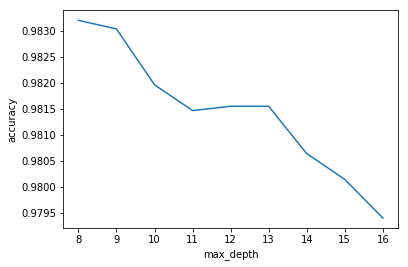

In [60]:
# Decision tree classification (tune max_depth)
max_depth_list = [8,9,10,11,12,13,14,15,16]
dtree_accuracy_temp = []
for max_depth in max_depth_list:
    dtree_model_temp = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train_21)
    dtree_accuracy_temp.append(dtree_model_temp.score(X_test, y_test_21))
    
plt.plot(max_depth_list, dtree_accuracy_temp)
plt.ylabel('accuracy')
plt.xlabel('max_depth')

In [61]:
max_depth = max_depth_list[dtree_accuracy_temp.index(max(dtree_accuracy_temp))]
dtree_model = DecisionTreeClassifier(max_depth = max_depth).fit(X_train, y_train_21)
dtree_predictions = dtree_model.predict(X_test)
dtree_accuracy = dtree_model.score(X_test, y_test_21)
dtree_cm = confusion_matrix(y_test_21, dtree_predictions)
print('Decision tree test accuracy: ', dtree_accuracy)
print('\n')
print('Decision tree confusion matrix:\n', dtree_cm)
print('\n')
print('Decision tree important features:\n', dtree_model.feature_importances_)

Decision tree test accuracy:  0.9830382260466656


Decision tree confusion matrix:
 [[11880    11]
 [  194     1]]


Decision tree important features:
 [0.04823442 0.00747503 0.01396568 0.04874773 0.         0.
 0.05129121 0.02053901 0.008418   0.         0.01396568 0.06590143
 0.         0.         0.         0.         0.02128103 0.04344877
 0.04344877 0.02034334 0.01044667 0.         0.         0.
 0.         0.0167747  0.0186209  0.01163806 0.         0.
 0.         0.0289714  0.         0.         0.02696129 0.
 0.         0.         0.         0.         0.         0.07084154
 0.00730764 0.01392654 0.01713112 0.         0.         0.01396568
 0.         0.0298697  0.         0.         0.         0.02570165
 0.         0.         0.         0.01067878 0.01023519 0.
 0.         0.         0.         0.         0.         0.05386552
 0.         0.         0.         0.         0.00145892 0.01396568
 0.         0.0186209  0.         0.         0.         0.
 0.         0.         0.

In [62]:
# Random Forest Classifier (tune n_estimators)
# Can only handle small n_estimators, or the memory will exceed.

rf_model = RandomForestClassifier(n_estimators = 40, n_jobs = -1).fit(X_train, y_train_21)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = rf_model.score(X_test, y_test_21)
rf_cm = confusion_matrix(y_test_21, rf_predictions)
print('RF test accuracy: ', rf_accuracy)
print('\n')
print('RF confusion matrix:\n', rf_cm)
print('\n')
print('RF important features:\n', rf_model.feature_importances_)

RF test accuracy:  0.9838656296541453


RF confusion matrix:
 [[11891     0]
 [  195     0]]


RF important features:
 [1.63099712e-02 1.77632756e-02 1.64495295e-02 2.92190463e-02
 1.77296596e-02 1.68813309e-02 9.95537291e-03 1.16428182e-02
 1.18099958e-02 1.75494945e-02 6.53338590e-03 1.69829945e-02
 1.09809472e-02 1.25912190e-02 1.91107884e-02 8.26874402e-03
 1.09475656e-02 8.83813829e-03 7.24766277e-03 1.26147455e-02
 6.43776888e-03 1.04629652e-02 1.95775112e-02 1.07731820e-02
 8.24121503e-03 9.26713240e-03 2.24997095e-02 8.98751982e-03
 1.44841900e-02 7.66553246e-03 6.21440709e-03 9.99275232e-03
 8.31850129e-03 1.41788486e-02 1.81904523e-02 1.54329521e-02
 9.62908362e-03 1.11381096e-02 1.25547710e-02 7.08041331e-03
 9.93461923e-03 1.72287423e-02 1.46146765e-02 2.34772910e-02
 5.61926161e-03 1.49234172e-02 5.64306229e-03 6.27449895e-03
 1.90199247e-03 2.77177314e-02 1.11134940e-02 6.89508833e-03
 1.08805073e-02 1.58437354e-02 8.73187899e-03 4.85846529e-03
 1.44727943e-02 5.50015985e

# Appendix: Supervised learning methods that exceed our computation limits

In [ ]:
from sklearn.svm import SVC

# SVM classification (tune C)
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
svm_accuracy = svm_model_linear.score(X_test, y_test)
svm_cm = confusion_matrix(y_test, svm_predictions)
print(svm_accuracy)
print('\n')
print(svm_cm)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

# One-vs-Rest classification
OVR_model = OneVsRestClassifier(LinearSVC(random_state=0), n_jobs = -1).fit(X_train, y_train)
OVR_predictions = OVR_model.predict(X_test)
OVR_accuracy = OVR_model.score(X_test, y_test)
OVR_cm = confusion_matrix(y_test, OVR_predictions)
print(OVR_accuracy)
print('\n')
print(OVR_cm)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Multiclass Logistic
logit_model = LogisticRegression(solver = 'lbfgs', n_jobs = -1).fit(X_train, y_train)
logit_predictions = logit_model.predict(X_test)
logit_accuracy = logit_model.score(X_test, y_test)
logit_cm = confusion_matrix(y_test, logit_predictions)
print('Logistic test accuracy:\n', logit_accuracy)
print('\n')
print('Logistic confusion matrix:\n', logit_cm)